In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_orig = pd.read_csv('dataset/cluster_dataset.csv')
df_orig.shape

(2212, 11)

In [4]:
df_orig.head()

,Age,Education,Rel_Status,Income,TotalSpend,Wines,Fruits,Meat,Fish,Sweet,Gold
0,55,Graduation,Single,58138.0,1617,635,88,546,172,88,88
1,60,Graduation,Single,46344.0,27,11,1,6,2,1,6
2,48,Graduation,Coupled,71613.0,776,426,49,127,111,21,42
3,30,Graduation,Coupled,26646.0,53,11,4,20,10,3,5
4,33,PhD,Coupled,58293.0,422,173,43,118,46,27,15


In [5]:
# def encode_and_bind(dataframe, feature):
#     dummies = pd.get_dummies(dataframe[[feature]])
#     res = pd.concat([dummies, dataframe], axis=1)
#     res = res.drop([feature], axis=1)
#     return(res) 

In [6]:
# df = encode_and_bind(dataframe=df, feature='Education')
# df = encode_and_bind(df, 'Rel_Status')
# df.head(10)

In [7]:
df = df_orig.copy()

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Education'] = le.fit_transform(df['Education'])
df['Rel_Status'] = le.fit_transform(df['Rel_Status'])
df.head(10)

,Age,Education,Rel_Status,Income,TotalSpend,Wines,Fruits,Meat,Fish,Sweet,Gold
0,55,2,1,58138.0,1617,635,88,546,172,88,88
1,60,2,1,46344.0,27,11,1,6,2,1,6
2,48,2,0,71613.0,776,426,49,127,111,21,42
3,30,2,0,26646.0,53,11,4,20,10,3,5
4,33,4,0,58293.0,422,173,43,118,46,27,15
5,46,3,0,62513.0,716,520,42,98,0,42,14
6,41,2,1,55635.0,590,235,65,164,50,49,27
7,28,4,0,33454.0,169,76,10,56,3,1,23
8,39,4,0,30351.0,46,14,0,24,3,3,2
9,64,4,0,5648.0,49,28,0,6,1,1,13


In [9]:
df = df.reindex(columns=(['Rel_Status'] + list([a for a in df.columns if a != 'Rel_Status']) ))
df = df.reindex(columns=(['Education'] + list([a for a in df.columns if a != 'Education']) ))
df.head()

,Education,Rel_Status,Age,Income,TotalSpend,Wines,Fruits,Meat,Fish,Sweet,Gold
0,2,1,55,58138.0,1617,635,88,546,172,88,88
1,2,1,60,46344.0,27,11,1,6,2,1,6
2,2,0,48,71613.0,776,426,49,127,111,21,42
3,2,0,30,26646.0,53,11,4,20,10,3,5
4,4,0,33,58293.0,422,173,43,118,46,27,15


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[df.columns[2:]] = pd.DataFrame(scaler.fit_transform(df[df.columns[2:]]), columns=df.columns[2:])
df.head(10)

,Education,Rel_Status,Age,Income,TotalSpend,Wines,Fruits,Meat,Fish,Sweet,Gold
0,2,1,0.927582,0.287105,1.676245,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576
1,2,1,1.353640,-0.260882,-0.963297,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642
2,2,0,0.331100,0.913196,0.280110,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254
3,2,0,-1.202709,-1.176114,-0.920135,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987
4,4,0,-0.947074,0.294307,-0.307562,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545
5,3,0,0.160677,0.490381,0.180505,0.636663,0.394373,-0.307889,-0.687527,0.363993,-0.578889
6,2,1,-0.265381,0.170807,-0.028667,-0.208416,0.973207,-0.013514,0.225554,0.534385,-0.327416
7,4,0,-1.373133,-0.859793,-0.727564,-0.679881,-0.410961,-0.495218,-0.632742,-0.634019,-0.404792
8,4,0,-0.435805,-1.003968,-0.931755,-0.863722,-0.662628,-0.637946,-0.632742,-0.585335,-0.811019
9,4,0,1.694487,-2.151748,-0.926775,-0.822210,-0.662628,-0.718230,-0.669265,-0.634019,-0.598234


In [11]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

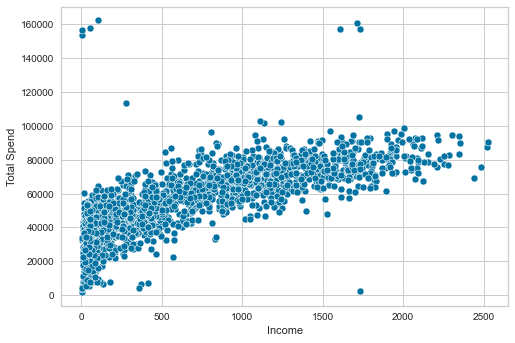

In [12]:
X = df_orig[['Income', 'TotalSpend']]
pl = sns.scatterplot(y=X['Income'], x=X['TotalSpend'])
plt.xlabel('Income')
plt.ylabel('Total Spend')
plt.show()

In [13]:
X = df[df.columns[:5]]
X.head()

,Education,Rel_Status,Age,Income,TotalSpend
0,2,1,0.927582,0.287105,1.676245
1,2,1,1.353640,-0.260882,-0.963297
2,2,0,0.331100,0.913196,0.280110
3,2,0,-1.202709,-1.176114,-0.920135
4,4,0,-0.947074,0.294307,-0.307562


In [14]:
from sklearn.decomposition import PCA
pca = PCA()
pca_df = pd.DataFrame(pca.fit_transform(X), columns=X.columns)
pca_df.head()

,Education,Rel_Status,Age,Income,TotalSpend
0,1.360395,0.659962,-0.758060,-0.825192,-0.885467
1,-0.508626,-0.527571,-1.508185,-0.581770,0.501466
2,0.723357,0.554104,-0.392298,0.428057,0.369737
3,-1.812110,0.119238,0.726672,0.327885,-0.158037
4,0.270110,-1.047000,1.503064,0.453913,0.378911


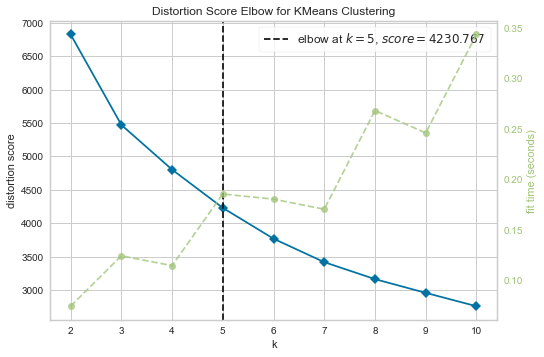

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
model = KMeans()
visualizer = KElbowVisualizer(model)
visualizer.fit(pca_df)
visualizer.show()

In [16]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=4)
ac_df = ac.fit_predict(pca_df)
df['Cluster'] = ac_df
df_orig['Cluster'] = ac_df
df_orig.head(10)

,Age,Education,Rel_Status,Income,TotalSpend,Wines,Fruits,Meat,Fish,Sweet,Gold,Cluster
0,55,Graduation,Single,58138.0,1617,635,88,546,172,88,88,3
1,60,Graduation,Single,46344.0,27,11,1,6,2,1,6,2
2,48,Graduation,Coupled,71613.0,776,426,49,127,111,21,42,1
3,30,Graduation,Coupled,26646.0,53,11,4,20,10,3,5,0
4,33,PhD,Coupled,58293.0,422,173,43,118,46,27,15,2
5,46,Master,Coupled,62513.0,716,520,42,98,0,42,14,2
6,41,Graduation,Single,55635.0,590,235,65,164,50,49,27,1
7,28,PhD,Coupled,33454.0,169,76,10,56,3,1,23,2
8,39,PhD,Coupled,30351.0,46,14,0,24,3,3,2,2
9,64,PhD,Coupled,5648.0,49,28,0,6,1,1,13,2


In [17]:
df_orig['Cluster'] = df_orig['Cluster'].astype('category')

C:\Users\saran\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Cluster Population')

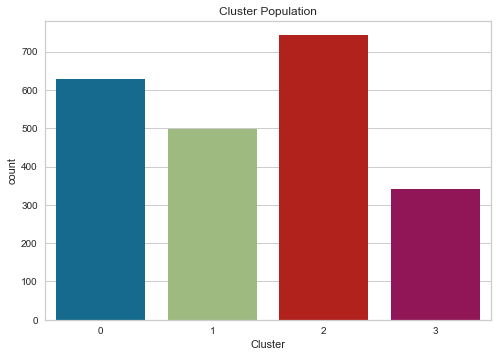

In [18]:
cplot = sns.countplot(df['Cluster'])
cplot.set_title('Cluster Population')
# plt.show()

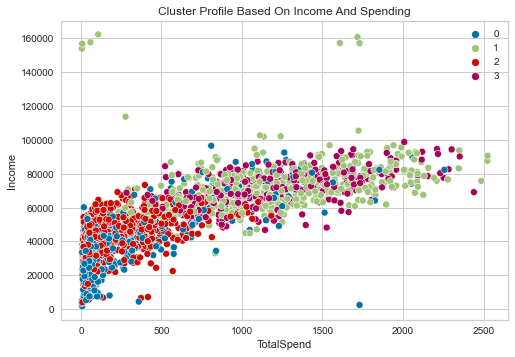

In [19]:
pl = sns.scatterplot(data=df_orig, x=df_orig['TotalSpend'], y=df_orig['Income'], hue=df_orig['Cluster'])
pl.set_title("Cluster Profile Based On Income And Spending")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Cluster Profile Based On Age And Spending')

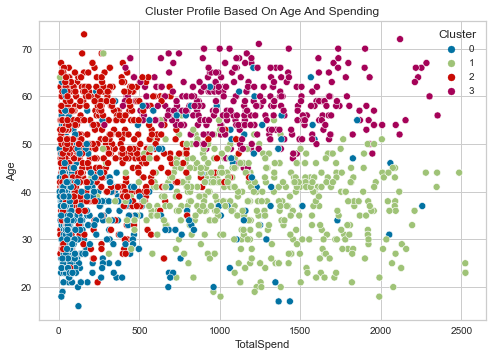

In [30]:
pl = sns.scatterplot(data=df_orig, x=df_orig['TotalSpend'], y=df_orig['Age'], hue=df_orig['Cluster'])
pl.set_title("Cluster Profile Based On Age And Spending")
# plt.legend()
# plt.show()

In [21]:
import plotly.express as px
import plotly.graph_objects as go

In [22]:
bins = [0, 25, 40, 50, 65, np.inf]
labels = ['<25', '25-40', '40-50', '50-65', '65+']
df_orig['AgeRange'] = pd.cut(df_orig['Age'], bins=bins, labels=labels)
df_orig['AgeRange'].value_counts()

25-40    785
50-60    630
40-50    623
<25      115
65+       59
Name: AgeRange, dtype: int64

In [23]:
fig = px.scatter(df_orig, x='TotalSpend', y='Income', color='Cluster', hover_data=['Age', 'Education', 'Rel_Status'])
fig.show()

In [24]:
df_orig.head()

,Age,Education,Rel_Status,Income,TotalSpend,Wines,Fruits,Meat,Fish,Sweet,Gold,Cluster,AgeRange
0,55,Graduation,Single,58138.0,1617,635,88,546,172,88,88,3,50-60
1,60,Graduation,Single,46344.0,27,11,1,6,2,1,6,2,50-60
2,48,Graduation,Coupled,71613.0,776,426,49,127,111,21,42,1,40-50
3,30,Graduation,Coupled,26646.0,53,11,4,20,10,3,5,0,25-40
4,33,PhD,Coupled,58293.0,422,173,43,118,46,27,15,2,25-40


In [25]:
plot_df = df_orig[df_orig.columns[1:5]].copy()
plot_df = pd.concat([df_orig['AgeRange'], plot_df], axis=1)
plot_df = pd.concat([plot_df, df_orig['Cluster']], axis=1)
plot_df.head()

,AgeRange,Education,Rel_Status,Income,TotalSpend,Cluster
0,50-60,Graduation,Single,58138.0,1617,3
1,50-60,Graduation,Single,46344.0,27,2
2,40-50,Graduation,Coupled,71613.0,776,1
3,25-40,Graduation,Coupled,26646.0,53,0
4,25-40,PhD,Coupled,58293.0,422,2


In [29]:
plot_df['Education'].value_counts()

Graduation    1115
PhD            480
Master         365
2n Cycle       198
Basic           54
Name: Education, dtype: int64

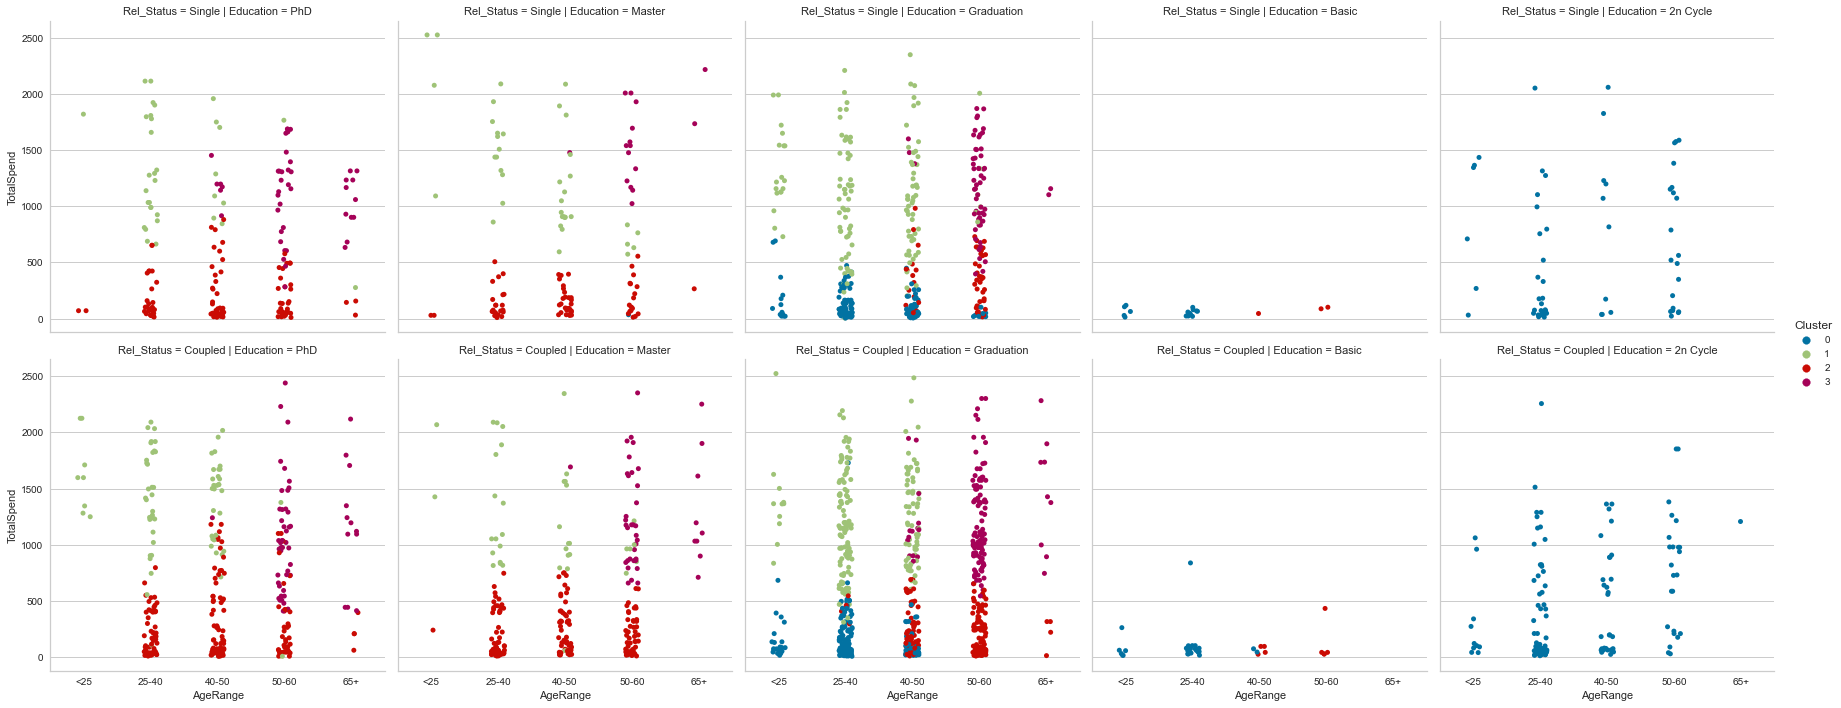

In [27]:
# g = sns.FacetGrid(data=plot_df, row='AgeRange', col='Education', hue='Cluster', height=5, aspect=1)
# g.map(sns.scatterplot, 'Rel_Status', 'TotalSpend')
col_order = ['PhD', 'Master', 'Graduation', 'Basic', '2n Cycle']
# custom_palette = sns.color_palette(palette=[ '#fb8a89', '#a6cee3', '#3f6284', '#a7b170', '#66a61e'])
ax = sns.catplot(data=plot_df, kind='strip', x='AgeRange', y='TotalSpend', row='Rel_Status', col='Education', col_order=col_order, hue='Cluster')


From the plots above, we can observe that people with higher income are likely to spend more on our products which is intuitively appropriate.
Customers with spouses are likely to spend more. This could be due to purchases for the family.
Most of our customers are graduates, followed by people holding PhD degrees. A significant cluster is also formed by people with Education listed as "2n Cycle". These are degrees equivalent to 2-year Masters' education, usually prominent in European countries like Italy and Poland. This hints at the fact that quite a few of our customers are internationals.
